In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import pingouin as pg
from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FPMcY4_9kTUpNg', sep=';')
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1000 non-null   int64 
 1   value              1000 non-null   object
 2   experimentVariant  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [5]:
df['value'] = df['value'].apply(lambda x: x.replace(',', '.'))
df['value'] = df['value'].astype('float64')

In [6]:
df = df.drop('Unnamed: 0', axis=1) # удаление ненужной колонки

In [7]:
df.groupby('experimentVariant').agg({'value': 'count'}).reset_index()

,experimentVariant,value
0,Control,500
1,Treatment,500


In [8]:
df.groupby('experimentVariant').agg({'value': 'mean'}).reset_index()

,experimentVariant,value
0,Control,10.026867
1,Treatment,27.321499


In [9]:
df.query('value < 1000').groupby('experimentVariant').agg({'value': 'mean'}).reset_index() # среднее без выбросов

,experimentVariant,value
0,Control,10.026867
1,Treatment,10.021716


In [10]:
df.groupby('experimentVariant').agg({'value': 'median'}).reset_index()

,experimentVariant,value
0,Control,10.018465
1,Treatment,10.025847


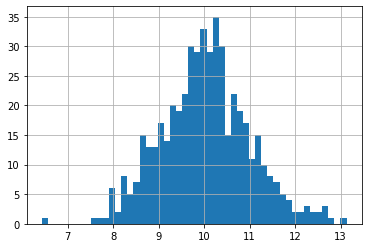

In [11]:
df.query('experimentVariant == "Control"').value.hist(bins=50)

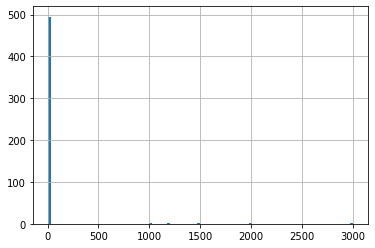

In [12]:
df.query('experimentVariant == "Treatment"').value.hist(bins=100)

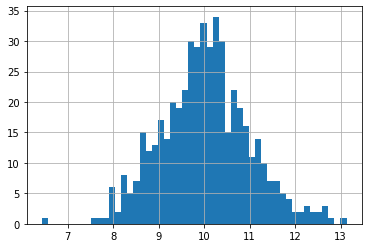

In [13]:
df.query('experimentVariant == "Treatment" & value < 1000').value.hist(bins=50) # без выбросов

## Промежуточные выводы
- была проведена небольшая предобработка данных (преобразования типа данных), проверка на пропуски значений
- произведен подсчет числа наблюдений в каждой группе
- на глаз распределения двух выборок похожи на нормальные (если из второй убрать выбросы)
- в идеале было бы хорошо убрать выбросы в тестовой группе

# 1. t-test

**Для данного теста необходимы следующие условия:**
- гомогенность дисперсий
- желательно, чтобы выборки имели нормальное распределение. В данном случае выборки по размеру достаточно велики, чтобы этим условием пренебречь

Проверим выборки на оба условия

**Проверка на равенство дисперсий**
- Проверка будет при помощи теста Левена


In [14]:
control = df.query('experimentVariant == "Control"').value
test    = df.query('experimentVariant == "Treatment"').value
print(ss.levene(control, test))
print(ss.levene(control, test, center='trimmed'))

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)
LeveneResult(statistic=0.06901983798404072, pvalue=0.7928295357803299)



*по дефолту тест Левена показал, что есть все основания отклонить нулевую гипотезу и гомогенности дисперсий*

*при параметре center='trimmed' (используется при тяжелых хвостах в распределении) тест не показал стат. значимых различий между дисперсиями*

**Проверка на нормальность**
- Большие выборки лучше проверять при помощи normaltest, т.к. тест Шапиро слишком придирчив при больших выборках. Однако проверим обоими тестами.

In [15]:
ss.shapiro(control) # распределение нормальное

ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)

In [16]:
ss.shapiro(test) # распределение не нормальное

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

In [17]:
ss.normaltest(control) # распределение нормальное

NormaltestResult(statistic=2.943458720256407, pvalue=0.2295282048395919)

In [18]:
ss.normaltest(test) # распределение не нормальное

NormaltestResult(statistic=929.5157667884811, pvalue=1.439513760946726e-202)

In [19]:
ss.kstest(control, 'norm') # тест Колмагорова - Смирнова говорит о том,что выборка не имеет нормального распределения

KstestResult(statistic=0.9999999999388864, pvalue=0.0)

In [20]:
ss.kstest(test, 'norm') # тест Колмагорова - Смирнова говорит о том,что выборка не имеет нормального распределения

KstestResult(statistic=0.9999999999388864, pvalue=0.0)

In [21]:
ss.ks_2samp(control, test) # выборки взяты из одного и того же распределения

KstestResult(statistic=0.01, pvalue=0.9999999999999999)

In [22]:
pg.normality(control)

,W,pval,normal
value,0.995925,0.224164,True


In [23]:
pg.normality(test)

,W,pval,normal
value,0.070389,1.093013e-43,False


### Выводы по форме распределений:
- 3/4 теста показали, что распределение контрольной группы имеет нормальное распределения
- ни один тест не указал на нормальность распределения тестовой группы

In [24]:
ss.ttest_ind(control, test) # есть стат.значимые различия между средними двух выборок

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

In [25]:
ss.ttest_ind(control, test, equal_var=False) # t-test Уэлча при различающихся дисперсиях - есть различия 

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.03869409943233407)

## Выводы по t-тесту:
- оба теста показали стат. значимую различие между средними двух выборок
- я бы не стал использовать данный тест, т.к. условия для него выполняются с большими допущениями

# 2. U-тест

- для данного теста нет каких - либо условий для дисперсий и форм распределения
- выборки должны быть независимыми

In [26]:
ss.mannwhitneyu(test, control)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

### Выводы по тесту Манна-Уитни
- стат. значимых различий между средними рангами двух групп нет

# 3. Bootstrap

- каких-либо ограничений для бутстрапа нет

In [33]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { 
            "ci": ci, 
            "p_value": p_value}

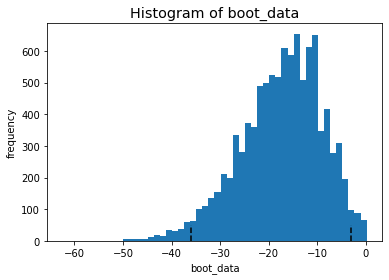

{'ci':                0
 0.025 -35.900940
 0.975  -3.079067,
 'p_value': 0.038569391240861756}

In [28]:
get_bootstrap(control, test, boot_it = 10000)

## Выводы по бутстрапу
- 0 не входит в 95% доверительный интервал, что дает основания отклонить нулевую гипотезу о равенстве средних в двух выборках

# Промежуточные выводы
- t-test и bootstrap показали значимые различия между средними двух выборок, тогда как U-тест не показал
- данные результаты показывают, что несколько выбросов в одной из выборок могут дать статистическое различие между двумя похожими выборками, важно правильно подобрать меру центральной тенденции для описания двух множеств

**Возможные выходы из ситуации**
- в данном случае для описания и сравнения выборок больше подходит медиана, которая менее чувствительна к выбросам
- либо же можно убрать выбросы
- либо провести логарифмирование значений выборок

## 1) Сравним медианы двух выборок, проведем бутстрап:

In [31]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { 
            "ci": ci, 
            "p_value": p_value}

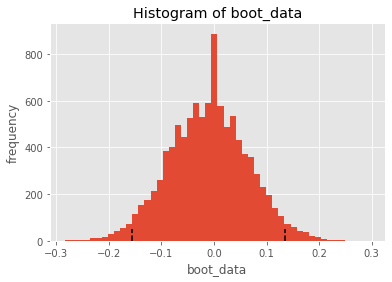

{'ci':               0
 0.025 -0.155905
 0.975  0.135217,
 'p_value': 0.9227081490057323}

In [32]:
get_bootstrap_median(control, test, boot_it = 10000)

## 2) уберем выбросы

In [36]:
test_norm = df.query('value < 1000 & experimentVariant == "Treatment"').value
test_norm

500    10.380495
501     9.546867
502    11.088215
503    10.147274
504     9.789808
         ...    
990    10.916229
991    11.160869
992     8.202518
993     9.782199
994    10.484967
Name: value, Length: 495, dtype: float64

In [38]:
ss.levene(control, test_norm) # дисперсии равны

LeveneResult(statistic=0.004297981921358907, pvalue=0.9477421313655946)

In [39]:
pg.normality(test_norm)

,W,pval,normal
value,0.995552,0.171882,True


In [40]:
ss.ttest_ind(control, test_norm) # значимых различий между средними нет

Ttest_indResult(statistic=0.08299135107595523, pvalue=0.9338751428058142)

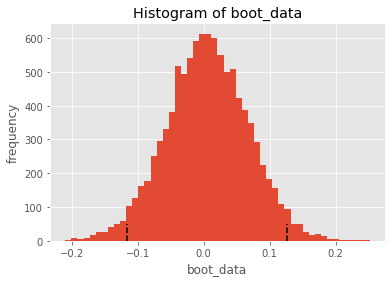

{'ci':               0
 0.025 -0.116092
 0.975  0.126527,
 'p_value': 0.9277574052584291}

In [41]:
get_bootstrap(control, test_norm, boot_it = 10000) # значимых различий между средними нет

## 3) прологарфмируем значения выборок

In [42]:
control_log = np.log(df.query('experimentVariant == "Control"').value)
test_log    = np.log(df.query('experimentVariant == "Treatment"').value)

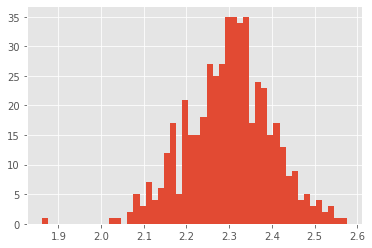

In [44]:
control_log.hist(bins=50)

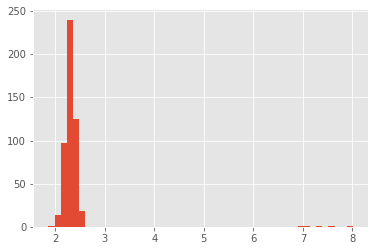

In [45]:
test_log.hist(bins=50)

In [46]:
pg.normality(test_log) # логарфмирование не помогло

,W,pval,normal
value,0.199734,1.526575e-41,False


In [48]:
ss.ttest_ind(control_log, test_log)

Ttest_indResult(statistic=-2.1379349959049563, pvalue=0.03276440163234999)

In [50]:
ss.mannwhitneyu(test_log, control_log)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

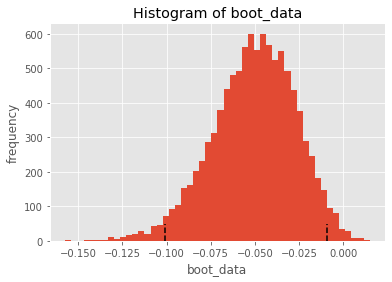

{'ci':               0
 0.025 -0.100661
 0.975 -0.009080,
 'p_value': 0.031110341750297327}

In [49]:
get_bootstrap(control_log, test_log, boot_it = 10000) 

# Итог
- без предобработки данных целесообразнее использовать тест Манна-Уитни для сравнения средних, т.к. он не чувствителен к выбросам
- в конкретном примере можно изменить данные или условия: убрать выбросы или сравнивать вместо средних медианы
- бутстрап не панацея, под каждый пример будет подходить определенный тест